## Setup

In [1]:
#!pip install pyarrow
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn

In [2]:
SEED = 10

## Read the data in

In [3]:
import pyarrow.parquet as pq
import pandas as pd

f = '/Users/siddharthsachdeva/Downloads/weekly-fd.parquet'
pdf = pd.read_parquet(f)

/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/siddharthsachdeva/.pyenv/versions/3.6.7/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
pdf.head()

,left_crop_url,right_crop_url,camera_metadata,left_crop_metadata,right_crop_metadata,pen_id,group_id,annotation_state_id,distance_from_camera
0,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152310499139117, ""focalLength...","{""width"": 2224, ""height"": 1468, ""x_coord"": 576...","{""width"": 2284, ""height"": 1507, ""x_coord"": 0, ...",57,57,6,0.659820
1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10152162251919987, ""focalLength...","{""width"": 2733, ""height"": 1046, ""x_coord"": 751...","{""width"": 2461, ""height"": 1027, ""x_coord"": 170...",59,59,6,0.487365
2,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.10148368515391534, ""focalLength...","{""width"": 3253, ""height"": 1301, ""x_coord"": 842...","{""width"": 3594, ""height"": 1258, ""x_coord"": 88,...",56,56,6,0.471675
3,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2413, ""height"": 1280, ""x_coord"": 162...","{""width"": 2250, ""height"": 1159, ""x_coord"": 114...",60,60,6,0.757097
4,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{""baseline"": 0.1017976434480721, ""focalLength""...","{""width"": 2067, ""height"": 811, ""x_coord"": 1919...","{""width"": 1973, ""height"": 727, ""x_coord"": 1428...",60,60,6,0.686996


## Filter and preprocess the features

In [5]:
pdf.shape

(2165, 9)

In [6]:
## Filter rows without ground truth depth

pdf = pdf[pdf.distance_from_camera.notnull()]
pdf.shape

(2165, 9)

In [7]:
pdf = pdf[pdf['camera_metadata'].apply(type) == str]
print(pdf['camera_metadata'].apply(type).value_counts())

<class 'str'>    2165
Name: camera_metadata, dtype: int64


In [8]:
pdf = pdf[pdf['left_crop_metadata'].apply(type) == str]
print(pdf['left_crop_metadata'].apply(type).value_counts())

<class 'str'>    2165
Name: left_crop_metadata, dtype: int64


In [9]:
import json

dict_columns = ['camera_metadata', 'left_crop_metadata']

for col in dict_columns:
    pdf = pdf[pdf[col].apply(type) == str]
    expanded = pdf[col].apply(json.loads).apply(pd.Series)
    for col in expanded:
        if expanded[col].isnull().sum() > 0:
            print(col + ' is null')
            print(expanded[col].isnull().value_counts())
    pdf = pd.concat([pdf, expanded], axis=1)

depth_mm is null
False    1961
True      204
Name: depth_mm, dtype: int64


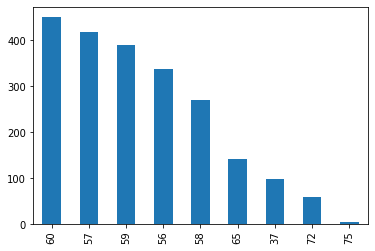

In [61]:
pdf.pen_id.value_counts().plot.bar()

In [10]:
pdf.columns

Index(['left_crop_url', 'right_crop_url', 'camera_metadata',
       'left_crop_metadata', 'right_crop_metadata', 'pen_id', 'group_id',
       'annotation_state_id', 'distance_from_camera', 'baseline',
       'focalLength', 'pixelCountWidth', 'focalLengthPixel',
       'imageSensorWidth', 'pixelCountHeight', 'imageSensorHeight',
       'stereoParametersUrl', 'width', 'height', 'x_coord', 'y_coord',
       'depth_mm', 'crop_area', 'quality_score', 'mean_luminance',
       'edge_detection_score', 'mean_green_luminance'],
      dtype='object')

In [11]:
pdf.shape

(2165, 27)

## Train a linear regression model

In [62]:
from itertools import combinations

dimension_features = ['width', 'height', 'x_coord', 'y_coord']
area_features = dimension_features + ['crop_area']
quality_features = ['edge_detection_score', 'mean_green_luminance', 'mean_luminance', 'quality_score']
camera_features = ['focalLength', 'focalLengthPixel', 'imageSensorHeight', 'imageSensorWidth']

featuregroups = [dimension_features, quality_features, camera_features]
featuresets = [dimension_features, dimension_features + camera_features, dimension_features+camera_features+quality_features]
featuresets

[['width', 'height', 'x_coord', 'y_coord'],
 ['width',
  'height',
  'x_coord',
  'y_coord',
  'focalLength',
  'focalLengthPixel',
  'imageSensorHeight',
  'imageSensorWidth'],
 ['width',
  'height',
  'x_coord',
  'y_coord',
  'focalLength',
  'focalLengthPixel',
  'imageSensorHeight',
  'imageSensorWidth',
  'edge_detection_score',
  'mean_green_luminance',
  'mean_luminance',
  'quality_score']]

In [14]:
from sklearn.linear_model import LinearRegression

help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model.base:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin, sklearn.base.MultiOutputMixin)
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False``.
 |  
 |  copy_X : boolean, optional, default True
 |      If True, X will be copied; e

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

hyperparams = {LinearRegression: {'normalize': True}}

def check_features(featureset):
    for feat in featureset:
        try:
            assert pdf[feat].isnull().sum() == 0
        except:
            print(feat)
            print(pdf[feat].isnull().sum())

def get_performance_report(y_true, y_pred, metrics=[explained_variance_score, mean_absolute_error, mean_squared_error]):
    report = {'evaluation': {m.__name__: m(y_true, y_pred) for m in metrics}}
    report['preds'] = y_pred
    report['y_true'] = y_true
    report['residuals'] = y_true - y_pred
    return report

def train_and_eval_model(
        df,
        cls, 
        featureset
    ):
    check_features(featureset)
    model = cls(**hyperparams[cls])
    X = df[featureset]
    y = df['distance_from_camera']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=SEED)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    report = get_performance_report(Y_test, pred)
    report['feature_importances'] = {feat: model.coef_[i] for i, feat in enumerate(featureset)}
    return report

def evaluate(cls, featureset, train_pen_specific=True):
    results = dict()
    for pen in pdf.pen_id.unique():
        this_pen_df = pdf[pdf.pen_id==pen]
        results[pen] = train_and_eval_model(this_pen_df, cls, featureset)
    return results

def plot_results(report, is_model=True):
    fig, axes = plt.subplots(nrows=len(report), ncols=3, figsize=(30,20))
    for i, pen in enumerate(report):
        print(f'Pen:{pen}')
        print(report[pen]['evaluation'])
        if is_model:
            pd.Series(report[pen]['feature_importances']).plot.bar(ax=axes[i][0])
        pd.Series(report[pen]['residuals']).plot.hist(bins=np.arange(-1, 1, 0.05), ax=axes[i][1])
        axes[i][2].scatter(report[pen]['preds'],report[pen]['y_true'])
        axes[i][2].set_xlim([0, 1])
        axes[i][2].set_ylim([0,1])

## How good is our baseline right now

Pen:57
{'explained_variance_score': 0.10554225843620002, 'mean_absolute_error': 0.190496966169703, 'mean_squared_error': 0.04115907702307037}
Pen:59
{'explained_variance_score': 0.12796656765400383, 'mean_absolute_error': 0.17502507970051953, 'mean_squared_error': 0.03613857754643118}
Pen:56
{'explained_variance_score': 0.17873857681822103, 'mean_absolute_error': 0.21736491862681376, 'mean_squared_error': 0.05229604198803666}
Pen:60
{'explained_variance_score': 0.05958691242415248, 'mean_absolute_error': 0.1980940499585907, 'mean_squared_error': 0.043871246998081766}
Pen:58
{'explained_variance_score': 0.2345401110828852, 'mean_absolute_error': 0.19254116836243243, 'mean_squared_error': 0.04092234096311701}
False    142
Name: depth_mm, dtype: int64
False    58
Name: depth_mm, dtype: int64
Pen:37
{'explained_variance_score': 0.06353601096801376, 'mean_absolute_error': 0.2216651024517111, 'mean_squared_error': 0.06044448575185078}
False    4
Name: depth_mm, dtype: int64
Pen:57
{'explaine

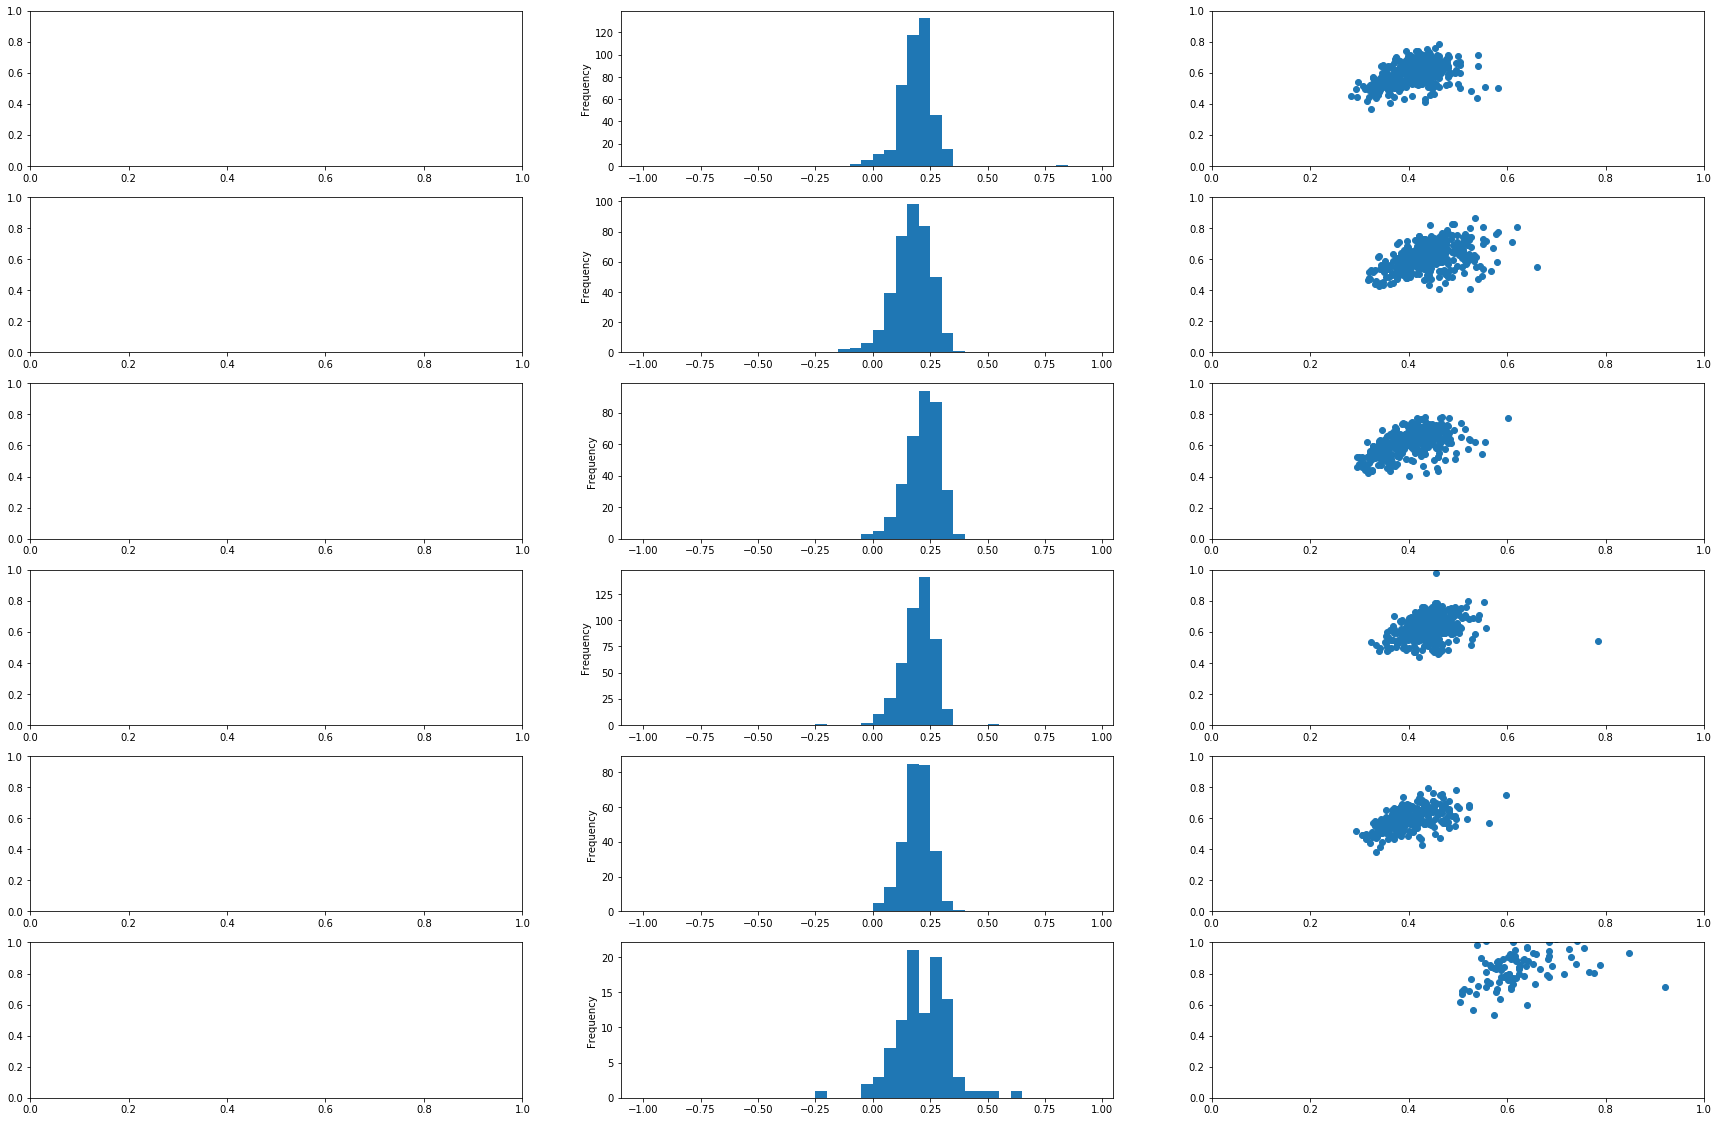

In [114]:
has_depth = pdf[pdf.depth_mm.notnull()]
has_depth_and_distance = pdf[pdf.distance_from_camera.notnull()]

results = dict()
for pen in has_depth_and_distance.pen_id.unique():
    this_pen_df = has_depth_and_distance[pdf.pen_id==pen]
    y_true, y_pred = this_pen_df.distance_from_camera, this_pen_df.depth_mm / 1000
    try:
        assert y_true.isnull().sum() == 0
        assert y_pred.isnull().sum() == 0, str(y_pred.notnull().value_counts())
        results[pen] = get_performance_report(y_true, y_pred)
        print(f'Pen:{pen}')
        print(results[pen]['evaluation'])
    except Exception as e:
        print(e)

plot_results(results, is_model=False)

No cells with both depth_mm and distance_from_camera!!!!

## Area

Pen:57
{'explained_variance_score': 0.13864855064580484, 'mean_absolute_error': 0.05931802771428568, 'mean_squared_error': 0.008401706234151771}
Pen:59
{'explained_variance_score': 0.16464032691316088, 'mean_absolute_error': 0.056801131876595745, 'mean_squared_error': 0.004934931194311343}
Pen:56
{'explained_variance_score': 0.318076486617175, 'mean_absolute_error': 0.05208594525323675, 'mean_squared_error': 0.0046175374485986145}
Pen:60
{'explained_variance_score': 0.09610033095911452, 'mean_absolute_error': 0.06124561268931129, 'mean_squared_error': 0.005509950418668372}
Pen:58
{'explained_variance_score': 0.16405037422106117, 'mean_absolute_error': 0.051416636952837845, 'mean_squared_error': 0.004383234820805939}
Pen:65
{'explained_variance_score': 0.32206564831251894, 'mean_absolute_error': 0.039614436916613455, 'mean_squared_error': 0.002520392132860412}
Pen:72
{'explained_variance_score': 0.35966202342325304, 'mean_absolute_error': 0.0637386709983964, 'mean_squared_error': 0.0067

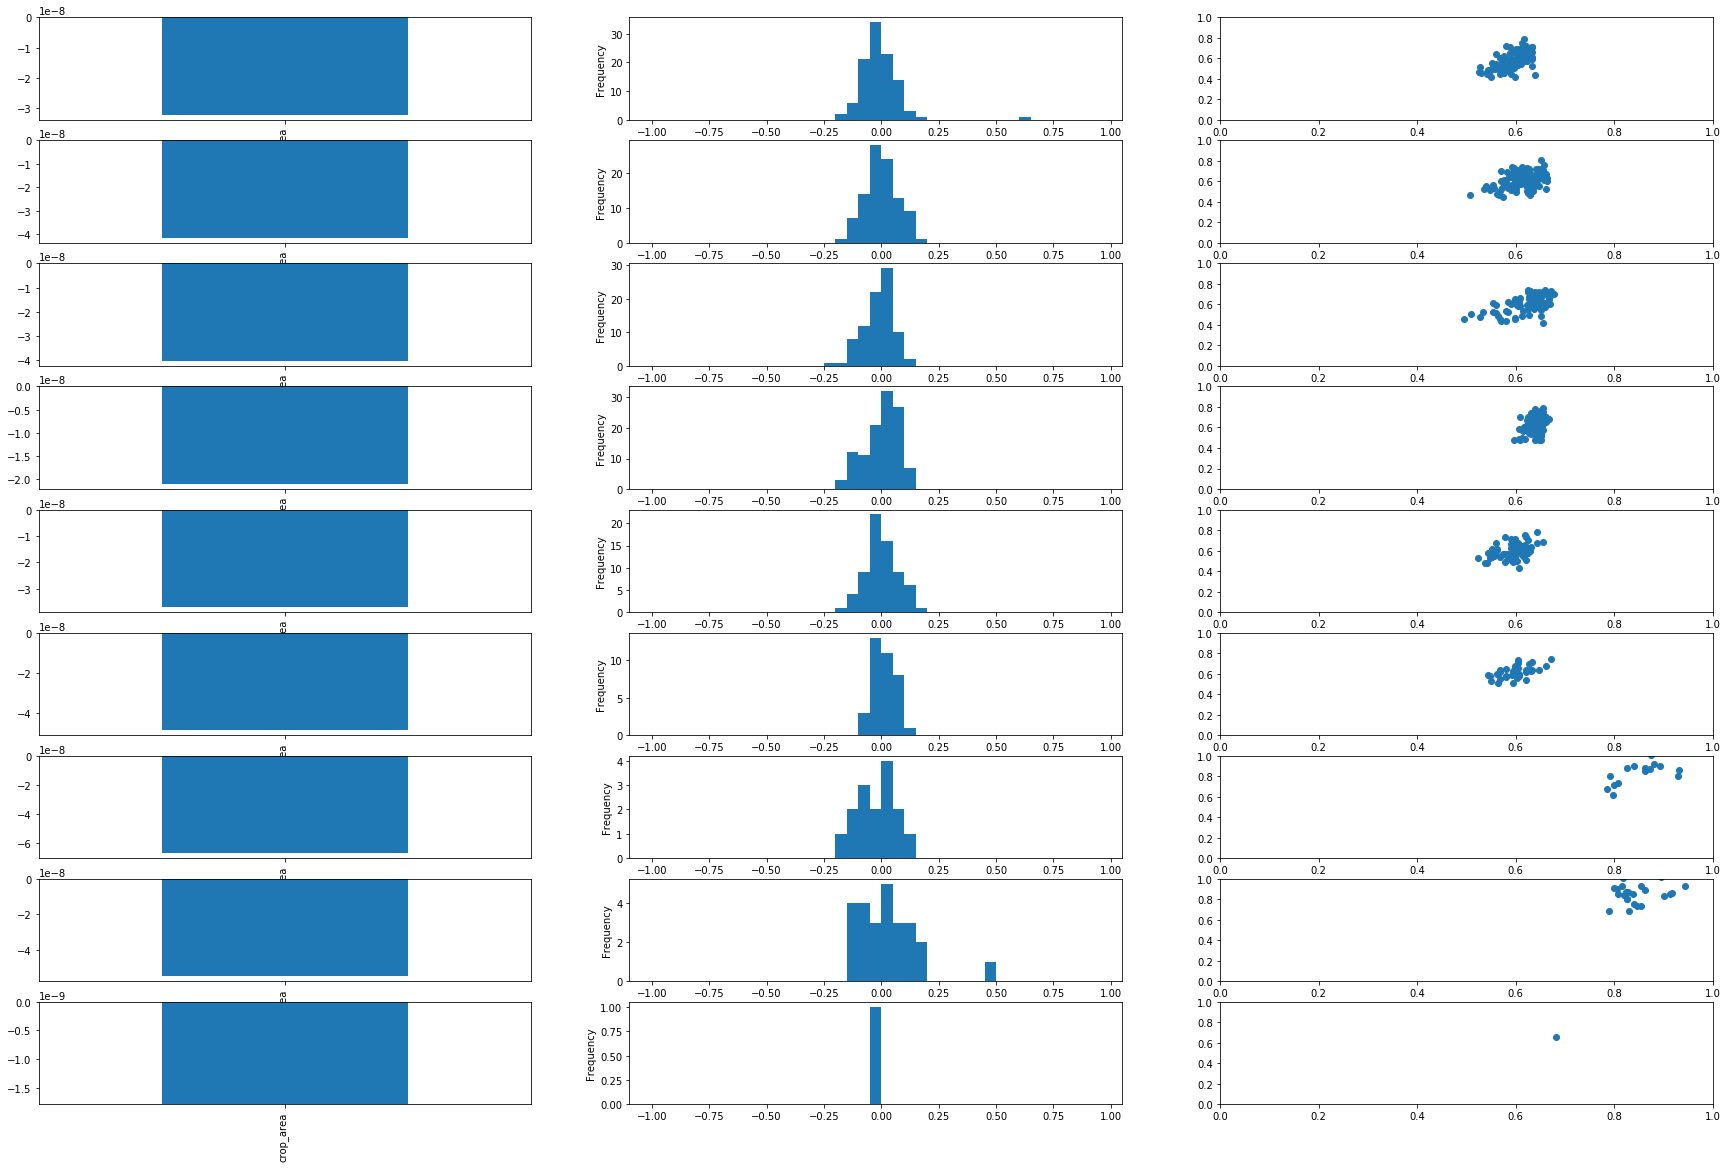

In [97]:
report = evaluate(LinearRegression, ['crop_area'])
plot_results(report)

## Dimension Features

Pen:57
{'explained_variance_score': 0.20833593331475708, 'mean_absolute_error': 0.05576701612491168, 'mean_squared_error': 0.007688524534971729}
Pen:59
{'explained_variance_score': 0.22229483156073349, 'mean_absolute_error': 0.054814975675508325, 'mean_squared_error': 0.004596894878990142}
Pen:56
{'explained_variance_score': 0.34215408244031864, 'mean_absolute_error': 0.052325016423584565, 'mean_squared_error': 0.004335690780189426}
Pen:60
{'explained_variance_score': 0.22277100020586593, 'mean_absolute_error': 0.056723698177712494, 'mean_squared_error': 0.00475372254484686}
Pen:58
{'explained_variance_score': 0.2709426728610487, 'mean_absolute_error': 0.047631070190886964, 'mean_squared_error': 0.0038160140261301627}
Pen:65
{'explained_variance_score': 0.5823645801541273, 'mean_absolute_error': 0.03330797206202373, 'mean_squared_error': 0.0018208117922603978}
Pen:72
{'explained_variance_score': 0.4107163234552137, 'mean_absolute_error': 0.061256741769695484, 'mean_squared_error': 0.00

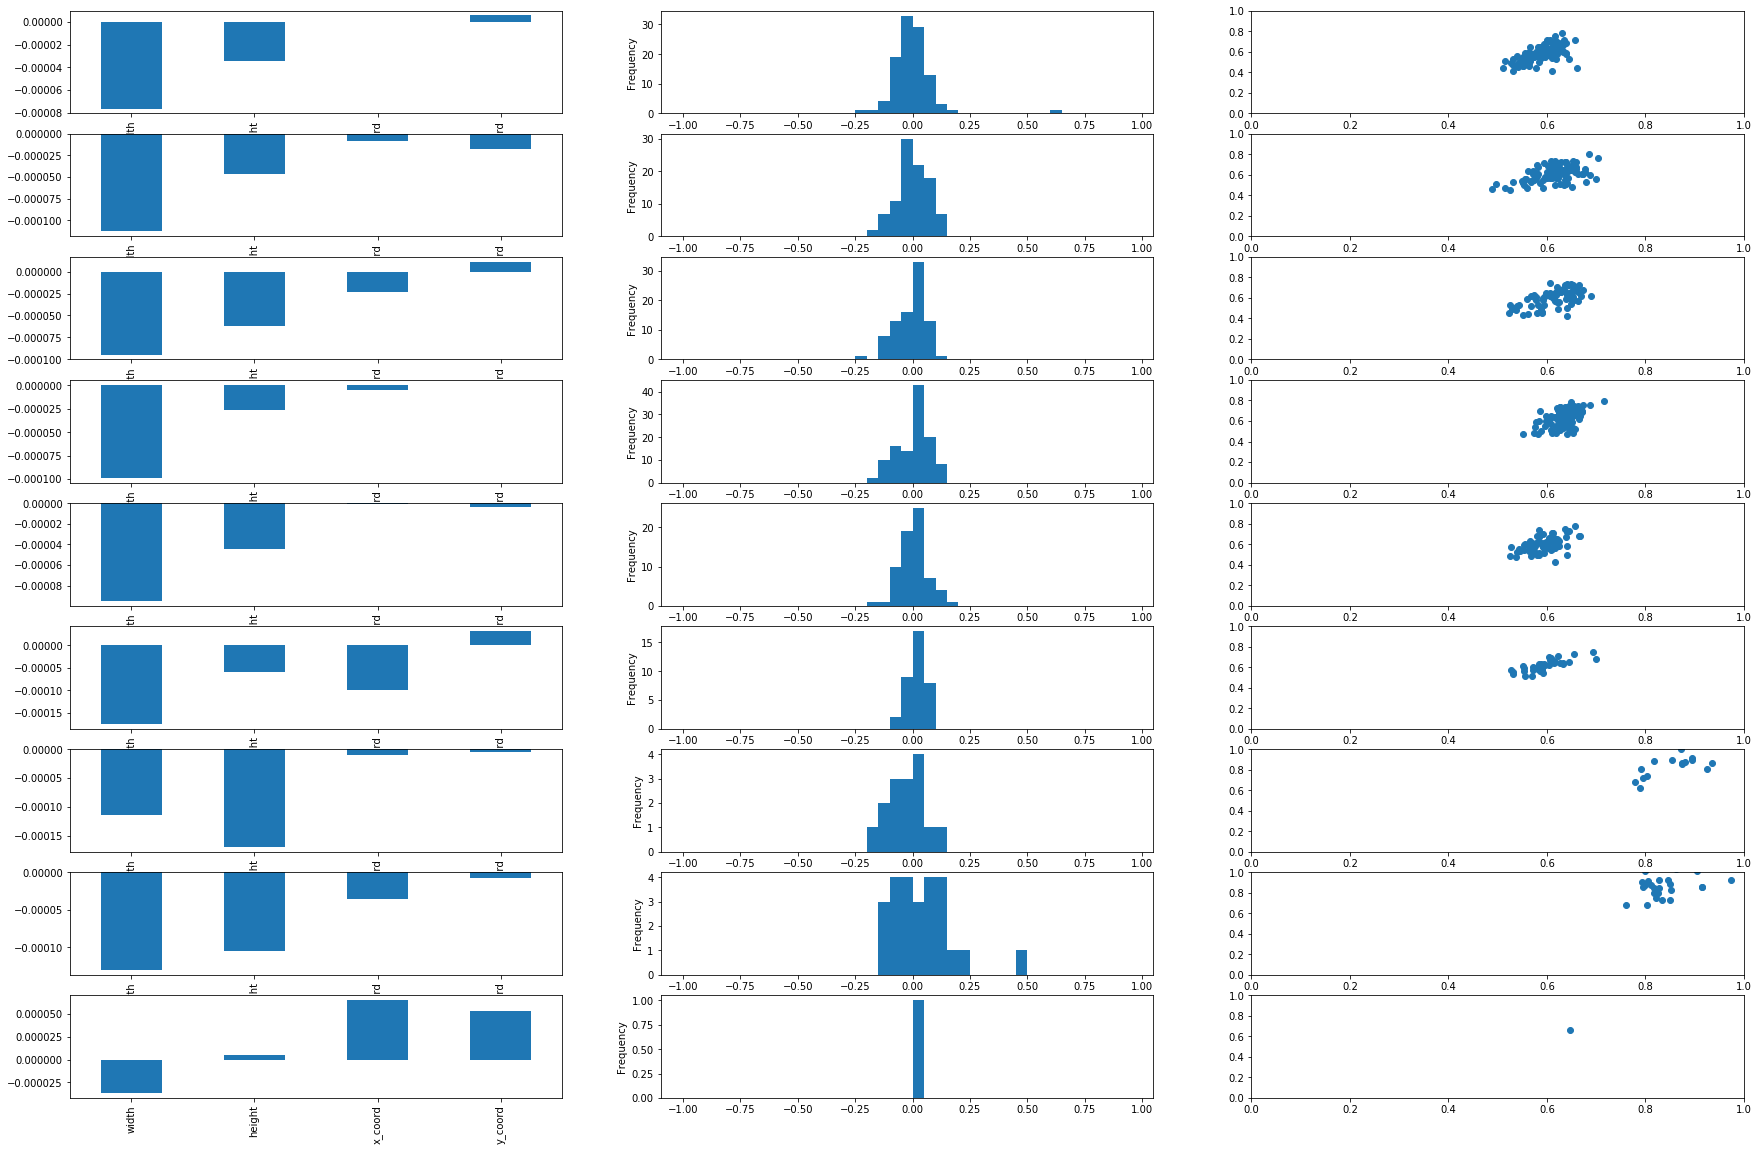

In [98]:
report = evaluate(LinearRegression, dimension_features)
plot_results(report)

## Area + Dimension Features

Pen:57
{'explained_variance_score': 0.206187118108364, 'mean_absolute_error': 0.05535591362875455, 'mean_squared_error': 0.00770785424726381}
Pen:59
{'explained_variance_score': 0.21504406796705833, 'mean_absolute_error': 0.05463623914679303, 'mean_squared_error': 0.0046390121327122185}
Pen:56
{'explained_variance_score': 0.35088962041133875, 'mean_absolute_error': 0.05171020397311886, 'mean_squared_error': 0.00427574850099323}
Pen:60
{'explained_variance_score': 0.2402592188110001, 'mean_absolute_error': 0.05602384647397293, 'mean_squared_error': 0.004652317926235695}
Pen:58
{'explained_variance_score': 0.24963549877955904, 'mean_absolute_error': 0.04790130925965258, 'mean_squared_error': 0.003918622139498786}
Pen:65
{'explained_variance_score': 0.5771340191436427, 'mean_absolute_error': 0.03299335683850498, 'mean_squared_error': 0.0017963034558805898}
Pen:72
{'explained_variance_score': 0.4845986379138054, 'mean_absolute_error': 0.05826116009166755, 'mean_squared_error': 0.0055328042

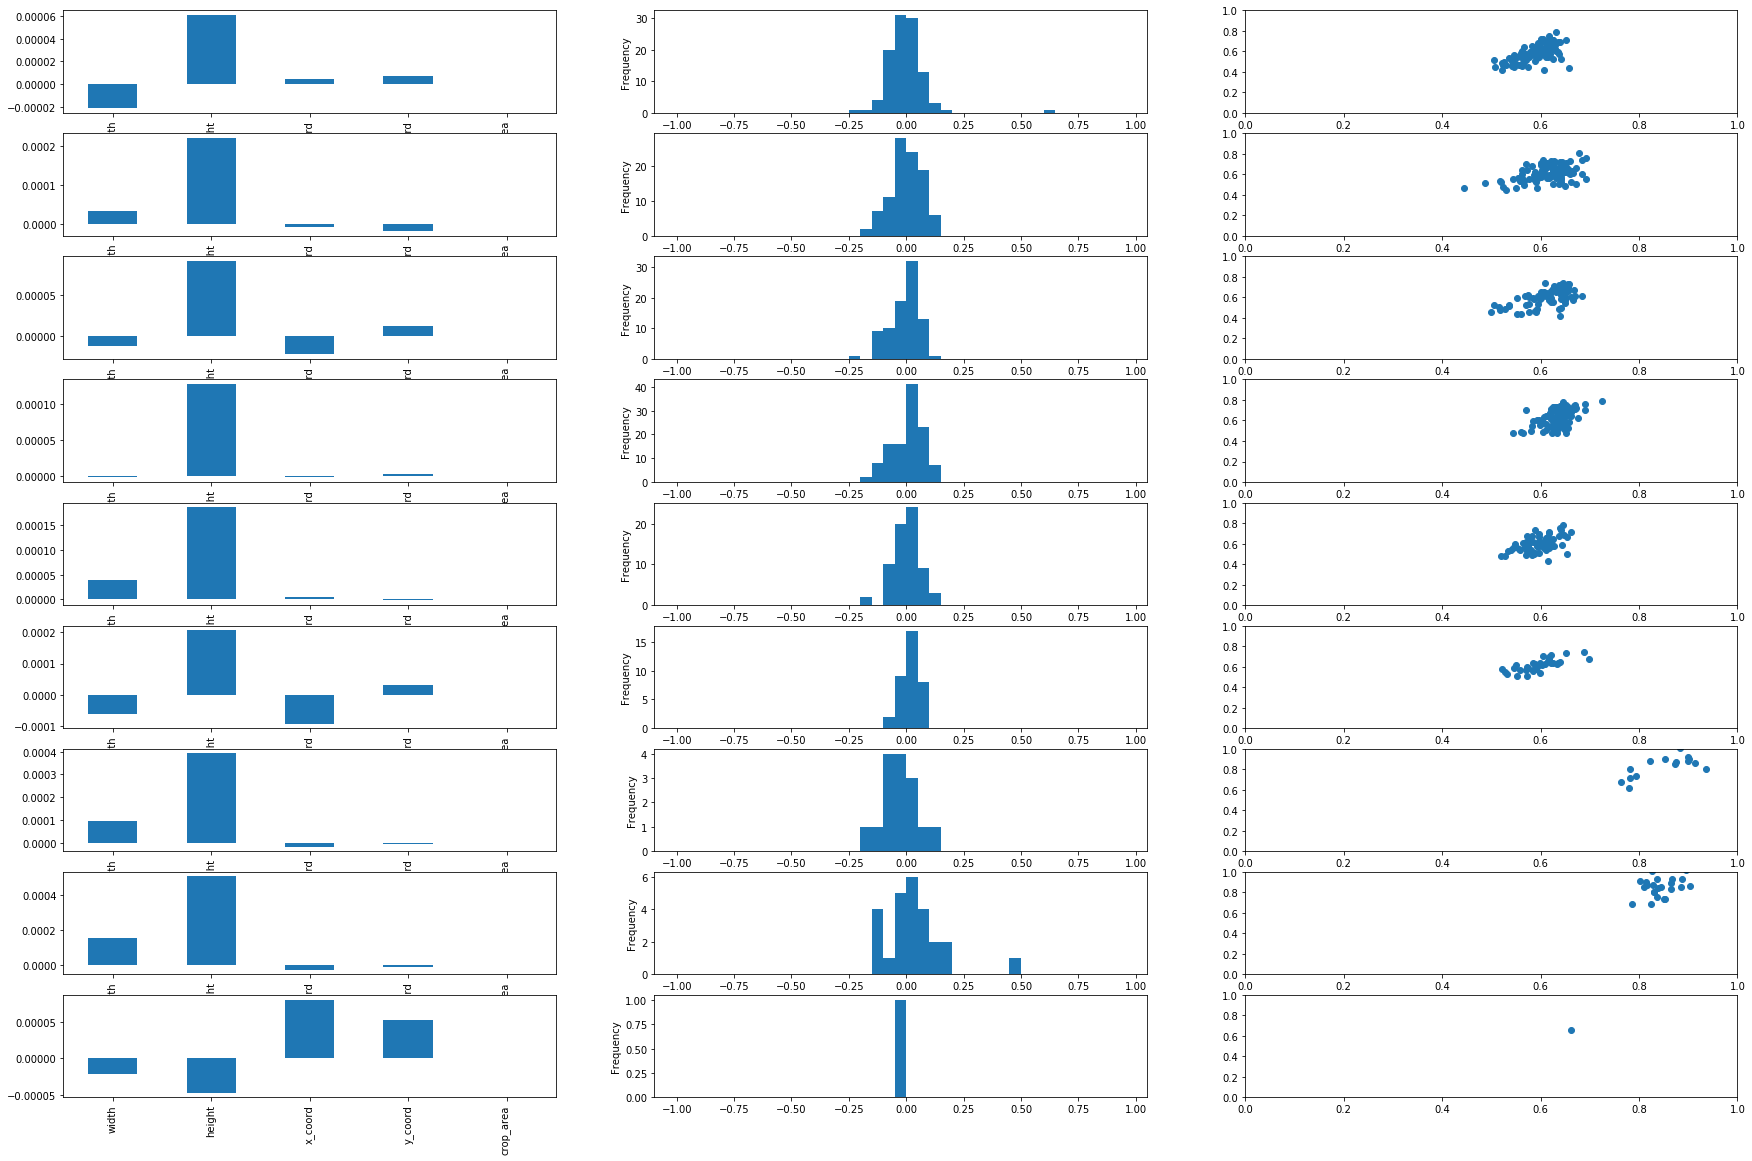

In [99]:
report = evaluate(LinearRegression, dimension_features + ['crop_area'])
plot_results(report)

## Dimension + Camera Features

Pen:57
{'explained_variance_score': 0.2083359333147572, 'mean_absolute_error': 0.05576701612491168, 'mean_squared_error': 0.007688524534971729}
Pen:59
{'explained_variance_score': -5.479479641357088e-05, 'mean_absolute_error': 4398046511104.61, 'mean_squared_error': 1.9342813113839444e+25}
Pen:56
{'explained_variance_score': 0.3421540824403184, 'mean_absolute_error': 0.052325016423584565, 'mean_squared_error': 0.004335690780189427}
Pen:60
{'explained_variance_score': 1.7664981033505e-08, 'mean_absolute_error': 0.6416599201945077, 'mean_squared_error': 0.4178130700786194}
Pen:58
{'explained_variance_score': 0.2709426728610491, 'mean_absolute_error': 0.04763107019088695, 'mean_squared_error': 0.003816014026130162}
Pen:65
{'explained_variance_score': 0.582364580154128, 'mean_absolute_error': 0.03330797206202358, 'mean_squared_error': 0.0018208117922603813}
Pen:72
{'explained_variance_score': 0.4107163234552137, 'mean_absolute_error': 0.061256741769695526, 'mean_squared_error': 0.006328634

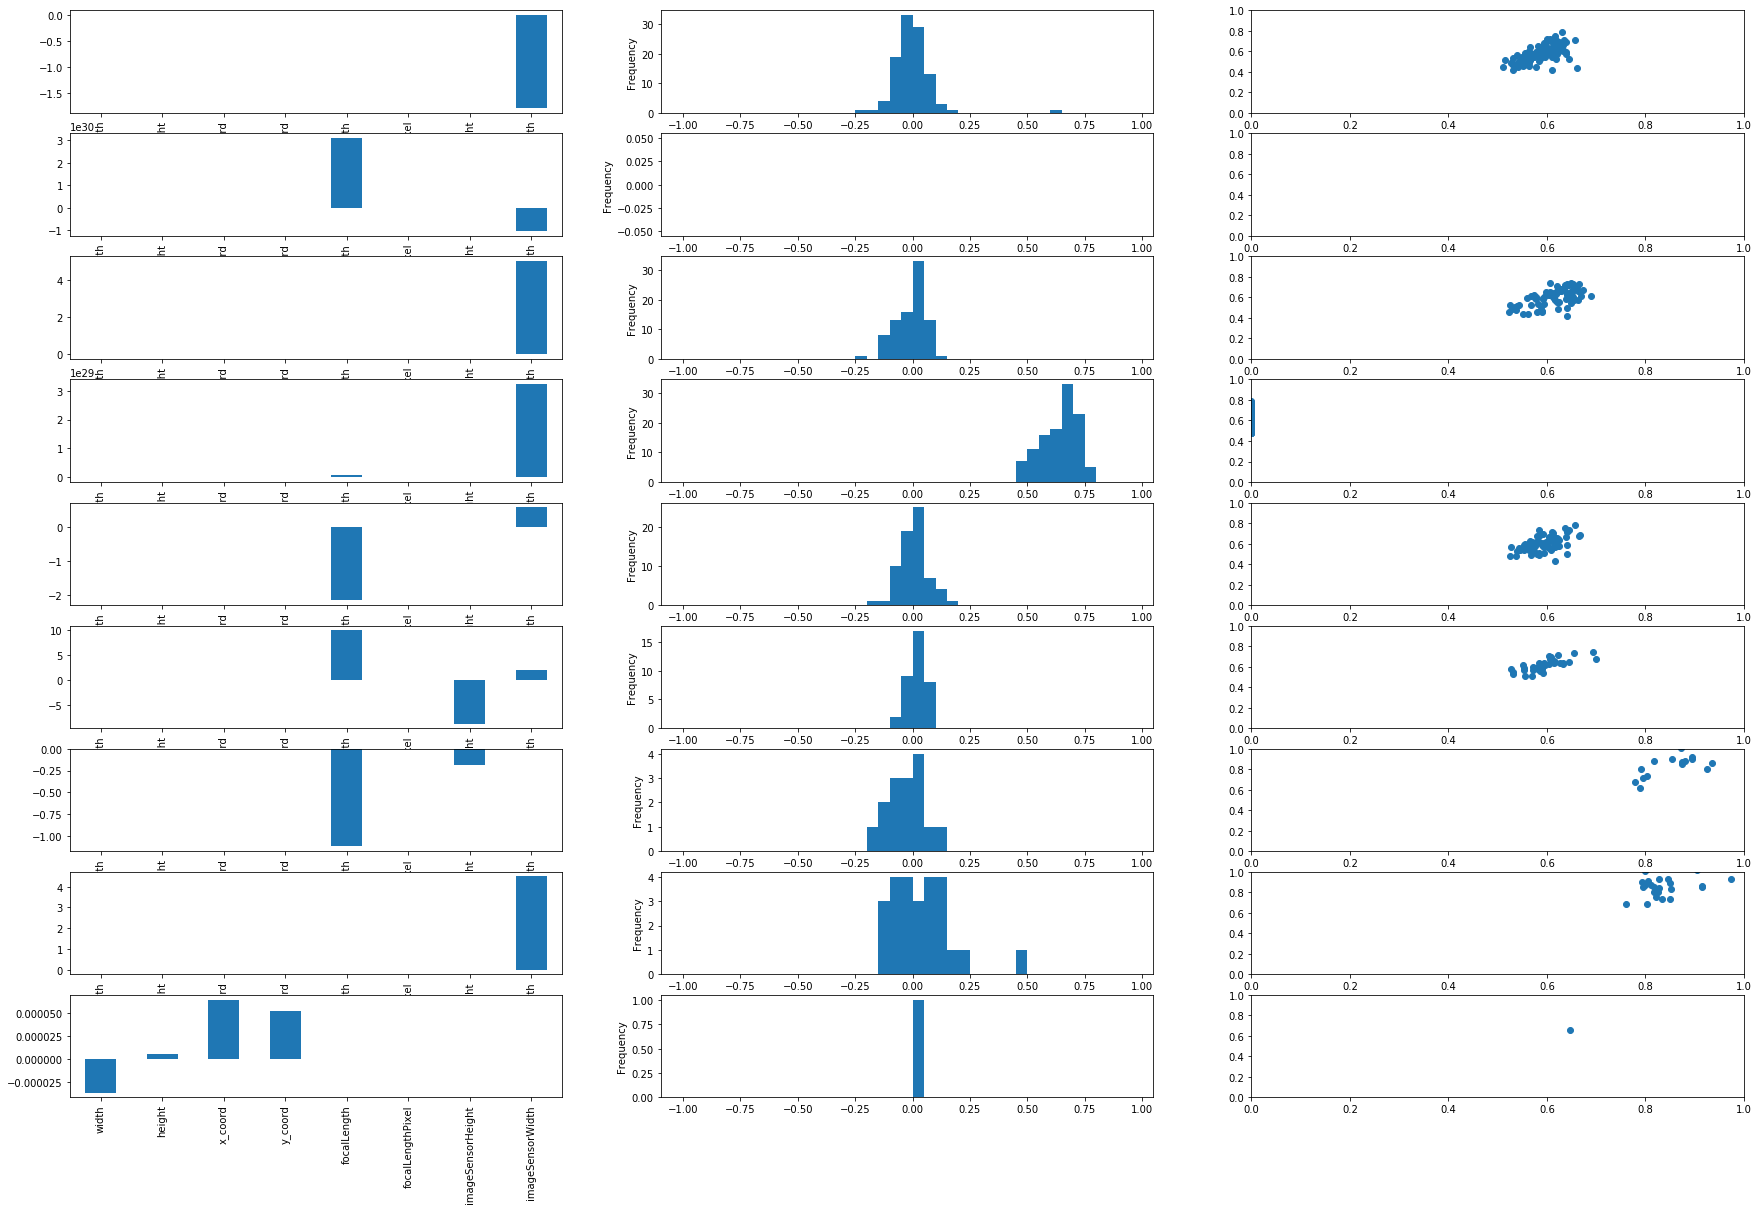

In [100]:
report = evaluate(LinearRegression, dimension_features + camera_features)
plot_results(report)

## Conclusion

We find that all of the above models perform significantly better than our baseline, and that the best model use either crop_area, or the coordinates, implying that the simple area of the fish in the image is the most important factor for determining depth. As a result, we recommend a linear regression model that uses the crop_area as input for to replace the existing solution for depth estimation in production